In [1]:
import datetime
from copy import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import ipywidgets
import pickle
import gc

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score

from sklearn.linear_model import LogisticRegression
import xgboost
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier, cv, Pool
import optuna
from optuna.integration import lightgbm as lgb
import tensorflow as tf

In [ ]:
pred_rf = pd.read_csv('submit/submit_RF29_1332.csv', names=('id', 'RandomForest'))
pred_xgb = pd.read_csv('submit/submit_XGBoost28_1827.csv', names=('id', 'XGBoost'))
pred_lgb = pd.read_csv('submit/submit_LGBM29_1414.csv', names=('id', 'LightGBM'))
pred_cb = pd.read_csv('submit/submit_CatBoost24_0350.csv', names=('id', 'CatBoost'))
pred_nn = pd.read_csv('submit/submit_NN17_1648.csv', names=('id', 'NN'))

In [ ]:
pred = pd.merge(pred_rf, pred_xgb, on='id')
pred = pd.merge(pred, pred_lgb, on='id')
pred = pd.merge(pred, pred_cb, on='id')
pred = pd.merge(pred, pred_nn, on='id')
pred.head(10)id

In [ ]:
corr = pred.corr()

plt.subplots(figsize=(6,6))
sns.heatmap(corr, annot=True, square=True, cmap='inferno')

In [ ]:
pred['pred'] = (pred.RandomForest * 0.04 + pred.XGBoost * 0.03 + pred.NN * 0.03
                + pred.LightGBM * 0.35 + pred.CatBoost * 0.55)
pred.head()

In [ ]:
now = datetime.datetime.now()

submission = pd.DataFrame({
    'ID':pred['id'],
    'pred':pred['pred']
})

file_name = 'submit/submit_' + now.strftime('%d_%H%M') + '.csv'

submission.to_csv(file_name, header=False, index=False)

# LogisticRegression

In [2]:
train_df = pd.read_csv('dataset/train_16_0246.csv')
test_df = pd.read_csv('dataset/test_16_0246.csv')

In [3]:
ID = train_df['id']
x = train_df.drop(columns=['y', 'id'])
y = train_df['y']

In [4]:
rf_model = pickle.load(open('models/RF_29_1334.pkl', 'rb'))
xgb_model = pickle.load(open('models/XG_28_1835.pkl', 'rb'))
lgb_model = pickle.load(open('models/LGBM_op24_0418.pkl', 'rb'))
lgb_dart_model = pickle.load(open('models/LGBM_dart_29_1416.pkl', 'rb'))

In [5]:
f_rf = rf_model.predict_proba(x)
first_rf = pd.DataFrame(f_rf)

f_xgb = xgb_model.predict_proba(x)
first_xgb = pd.DataFrame(f_xgb)

f_lgb = lgb_model.predict(x)
first_lgb = pd.DataFrame(f_lgb)

f_lgb_dart = lgb_dart_model.predict(x)
first_lgb_dart = pd.DataFrame(f_lgb_dart)

first_pred = np.column_stack((first_rf[1],first_xgb[1], first_lgb[0], first_lgb_dart[0]))
train_pred = pd.DataFrame(first_pred, columns=('RF', 'XGB', 'LGB', 'LGB_DART'))

train_pred = pd.concat([ID, train_pred, y], axis=1)
train_pred['id'] = [int(i) for i in train_pred['id']]
train_pred.head(-10)

,id,RF,XGB,LGB,LGB_DART,y
0,0,0.019100,0.003748,0.041840,-0.001197,0
1,1,0.182804,0.466265,0.178831,0.309165,1
2,2,0.009479,0.007407,0.036251,0.005431,0
3,3,0.016118,0.008354,0.040736,0.004744,0
4,4,0.173407,0.075168,0.118117,0.122778,0
...,...,...,...,...,...,...
27085,27085,0.026600,0.010796,0.046788,0.005757,0
27086,27086,0.021945,0.002702,0.041830,-0.009944,0
27087,27087,0.043832,0.023269,0.051748,0.026744,0
27088,27088,0.129261,0.163757,0.114841,0.120228,0


In [6]:
del train_df, test_df, ID, x, y

In [7]:
train_df = pd.read_csv('dataset/train_cat_16_2206.csv')
test_df = pd.read_csv('dataset/test_cat_16_2206.csv')

In [8]:
ID = train_df['id']
x = train_df.drop(columns=['y', 'id'])

In [9]:
cb_model = pickle.load(open('models/CatBoost_24_0835.pkl', 'rb'))

In [10]:
f_cb = cb_model.predict_proba(x)
first_cb = pd.DataFrame(f_cb)

tmp_train_pred = pd.concat([ID, first_cb[1]], axis=1)
tmp_train_pred['id'] = [int(i) for i in tmp_train_pred['id']]
tmp_train_pred.head(-10)

,id,1
0,0,0.005982
1,1,0.174154
2,2,0.006766
3,3,0.004269
4,4,0.148330
...,...,...
27085,27085,0.011141
27086,27086,0.003571
27087,27087,0.017806
27088,27088,0.182574


In [11]:
tr_pred = pd.merge(train_pred, tmp_train_pred, on='id')
tr_pred = tr_pred.rename(columns={1: 'CB'})

In [12]:
del train_df, test_df, x, ID, tmp_train_pred
gc.collect()

44

In [13]:
train_df = pd.read_csv('dataset/train_nn17_1435.csv')
test_df = pd.read_csv('dataset/test_nn17_1435.csv')

In [14]:
ID = train_df['id']
x = train_df.drop(columns=['id', 'y'])

In [15]:
nn_model = tf.keras.models.load_model('models/nn_model_0.8250201.h5', compile=False)

In [16]:
nn_pred = nn_model.predict(x)
first_nn = pd.DataFrame(nn_pred)

tmp_train_pred = pd.concat([ID, first_nn[0]], axis=1)
tmp_train_pred['id'] = [int(i) for i in tmp_train_pred['id']]
tmp_train_pred.head(-10)

,id,0
0,0,0.003727
1,1,0.105578
2,2,0.004983
3,3,0.010434
4,4,0.110732
...,...,...
27085,27085,0.025660
27086,27086,0.009491
27087,27087,0.025590
27088,27088,0.151165


In [17]:
tr_pred = pd.merge(tr_pred, tmp_train_pred, on='id')
tr_pred = tr_pred.rename(columns={0: 'NN'})

In [18]:
col = ['id', 'RF', 'XGB', 'LGB', 'LGB_DART', 'CB', 'NN', 'y']
tr_pred = tr_pred.reindex(col, axis=1)

del col
tr_pred.head(-10)

,id,RF,XGB,LGB,LGB_DART,CB,NN,y
0,0,0.019100,0.003748,0.041840,-0.001197,0.005982,0.003727,0
1,1,0.182804,0.466265,0.178831,0.309165,0.174154,0.105578,1
2,2,0.009479,0.007407,0.036251,0.005431,0.006766,0.004983,0
3,3,0.016118,0.008354,0.040736,0.004744,0.004269,0.010434,0
4,4,0.173407,0.075168,0.118117,0.122778,0.148330,0.110732,0
...,...,...,...,...,...,...,...,...
27085,27085,0.026600,0.010796,0.046788,0.005757,0.011141,0.025660,0
27086,27086,0.021945,0.002702,0.041830,-0.009944,0.003571,0.009491,0
27087,27087,0.043832,0.023269,0.051748,0.026744,0.017806,0.025590,0
27088,27088,0.129261,0.163757,0.114841,0.120228,0.182574,0.151165,0


In [19]:
del train_df, test_df, ID, x, tmp_train_pred
gc.collect()

726

In [20]:
x = tr_pred.iloc[:, 1:7]
y = tr_pred['y']
ID = tr_pred['id']

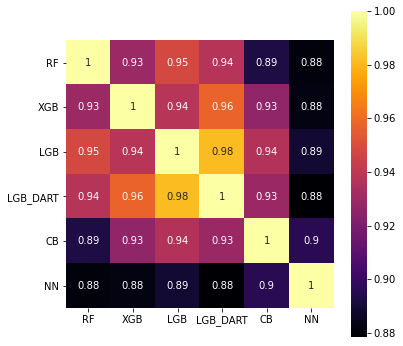

In [21]:
corr = x.corr()

plt.subplots(figsize=(6,6))
sns.heatmap(corr, annot=True, square=True, cmap='inferno')

In [22]:
def objective_lreg(trial):
    
    param_lreg = {
        'C': trial.suggest_loguniform('C', 1e-7, 1e+5)
    }
    
    lreg = LogisticRegression(**param_lreg, max_iter=1000, random_state=18)
    k = 5
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=18)
    
    scoring = 'roc_auc'
    cv_output = cross_validate(lreg, x, y, n_jobs=-1, scoring=scoring, cv=skf)
    
    return cv_output['test_score'].mean()

In [23]:
%%time

study_lreg = optuna.create_study(direction='maximize')
study_lreg.optimize(objective_lreg, n_trials=300)

lreg_best_params = study_lreg.best_params

[I 2020-08-31 13:30:46,783] Finished trial#0 resulted in value: 0.9235120170911578. Current best value is 0.9235120170911578 with parameters: {'C': 0.6124609258037539}.
[I 2020-08-31 13:30:47,422] Finished trial#1 resulted in value: 0.9167296796646086. Current best value is 0.9235120170911578 with parameters: {'C': 0.6124609258037539}.
[I 2020-08-31 13:30:47,629] Finished trial#2 resulted in value: 0.9207716173235407. Current best value is 0.9235120170911578 with parameters: {'C': 0.6124609258037539}.
[I 2020-08-31 13:30:47,862] Finished trial#3 resulted in value: 0.9171117025817569. Current best value is 0.9235120170911578 with parameters: {'C': 0.6124609258037539}.
[I 2020-08-31 13:30:47,998] Finished trial#4 resulted in value: 0.9109978490830152. Current best value is 0.9235120170911578 with parameters: {'C': 0.6124609258037539}.
[I 2020-08-31 13:30:48,201] Finished trial#5 resulted in value: 0.9167339404118463. Current best value is 0.9235120170911578 with parameters: {'C': 0.61246

CPU times: user 27 s, sys: 2.88 s, total: 29.8 s
Wall time: 57.6 s


In [24]:
print(study_lreg.best_params)
print('auc:', study_lreg.best_value)

{'C': 1.0292681340578658}
auc: 0.9236301727256111


In [25]:
lreg_best_params = {
        'C': 0.9236301727256111
}

In [26]:
lreg_model = LogisticRegression(**lreg_best_params, max_iter=1000, random_state=18)
lreg_model.fit(x, y)

LogisticRegression(C=0.9236301727256111, max_iter=1000, random_state=18)

In [27]:
lreg_p = lreg_model.predict_proba(x)
p_lreg = pd.DataFrame(lreg_p)

lreg_pred = pd.DataFrame({
    'id':ID,
    'lreg': p_lreg[1]
})

In [28]:
train_pred_df = pd.merge(tr_pred, lreg_pred, on='id')
train_pred_df.head(-10)

,id,RF,XGB,LGB,LGB_DART,CB,NN,y,lreg
0,0,0.019100,0.003748,0.041840,-0.001197,0.005982,0.003727,0,0.014807
1,1,0.182804,0.466265,0.178831,0.309165,0.174154,0.105578,1,0.830059
2,2,0.009479,0.007407,0.036251,0.005431,0.006766,0.004983,0,0.015737
3,3,0.016118,0.008354,0.040736,0.004744,0.004269,0.010434,0,0.015260
4,4,0.173407,0.075168,0.118117,0.122778,0.148330,0.110732,0,0.088182
...,...,...,...,...,...,...,...,...,...
27085,27085,0.026600,0.010796,0.046788,0.005757,0.011141,0.025660,0,0.014898
27086,27086,0.021945,0.002702,0.041830,-0.009944,0.003571,0.009491,0,0.012834
27087,27087,0.043832,0.023269,0.051748,0.026744,0.017806,0.025590,0,0.020725
27088,27088,0.129261,0.163757,0.114841,0.120228,0.182574,0.151165,0,0.101814


# PREDICT

In [29]:
pred_rf = pd.read_csv('submit/submit_RF29_1332.csv', names=('id', 'RandomForest'))
pred_xgb = pd.read_csv('submit/submit_XGBoost28_1827.csv', names=('id', 'XGBoost'))
pred_lgb = pd.read_csv('submit/submit_LGBM24_0416.csv', names=('id', 'LightGBM'))
pred_lgb_dart = pd.read_csv('submit/submit_LGBM29_1414.csv', names=('id', 'LightGBM_dart'))
pred_cb = pd.read_csv('submit/submit_CatBoost24_0350.csv', names=('id', 'CatBoost'))
pred_nn = pd.read_csv('submit/submit_NN17_1648.csv', names=('id', 'NN'))

In [30]:
pred = pd.merge(pred_rf, pred_xgb, on='id')
pred = pd.merge(pred, pred_lgb, on='id')
pred = pd.merge(pred, pred_lgb_dart, on='id')
pred = pd.merge(pred, pred_cb, on='id')
pred = pd.merge(pred, pred_nn, on='id')
pred.head(-10)

,id,RandomForest,XGBoost,LightGBM,LightGBM_dart,CatBoost,NN
0,0,0.671063,0.728266,0.359419,0.545177,0.874176,0.835058
1,1,0.077430,0.112043,0.092231,0.115565,0.055457,0.099198
2,2,0.037744,0.020388,0.050437,0.019731,0.024032,0.048758
3,3,0.002278,0.002376,0.035582,0.000824,0.003217,0.007241
4,4,0.103241,0.035205,0.071720,0.039956,0.042077,0.070299
...,...,...,...,...,...,...,...
18035,18035,0.085726,0.039344,0.078328,0.057052,0.037572,0.022707
18036,18036,0.054204,0.107310,0.077653,0.085267,0.066366,0.059807
18037,18037,0.002017,0.002429,0.034496,0.003664,0.002404,0.001839
18038,18038,0.018005,0.010760,0.053604,0.014745,0.030467,0.009364


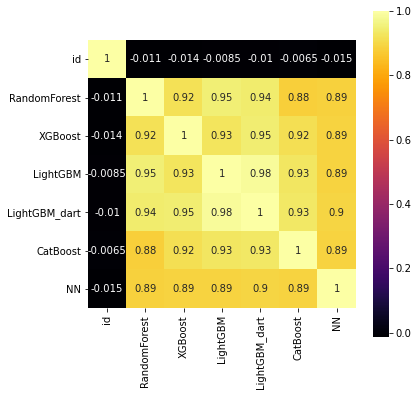

In [31]:
corr = pred.corr()

plt.subplots(figsize=(6,6))
sns.heatmap(corr, annot=True, square=True, cmap='inferno')

In [32]:
del x, y, lreg_p, lreg_pred, p_lreg
gc.collect()

64

In [33]:
x = pred.iloc[:, 1:]
ID = pred['id']

In [34]:
lreg_p = lreg_model.predict_proba(x)
p_lreg = pd.DataFrame(lreg_p)

lreg_pred = pd.DataFrame({
    'id':ID,
    'lreg': p_lreg[1]
})

In [35]:
pred_df = pd.merge(pred, lreg_pred, on='id')
pred_df.head(-10)

,id,RandomForest,XGBoost,LightGBM,LightGBM_dart,CatBoost,NN,lreg
0,0,0.671063,0.728266,0.359419,0.545177,0.874176,0.835058,0.985826
1,1,0.077430,0.112043,0.092231,0.115565,0.055457,0.099198,0.062941
2,2,0.037744,0.020388,0.050437,0.019731,0.024032,0.048758,0.016717
3,3,0.002278,0.002376,0.035582,0.000824,0.003217,0.007241,0.014166
4,4,0.103241,0.035205,0.071720,0.039956,0.042077,0.070299,0.022988
...,...,...,...,...,...,...,...,...
18035,18035,0.085726,0.039344,0.078328,0.057052,0.037572,0.022707,0.037013
18036,18036,0.054204,0.107310,0.077653,0.085267,0.066366,0.059807,0.056123
18037,18037,0.002017,0.002429,0.034496,0.003664,0.002404,0.001839,0.015025
18038,18038,0.018005,0.010760,0.053604,0.014745,0.030467,0.009364,0.019765


In [37]:
pred_df['pred'] = (
    pred_df.RandomForest * 0.01
    + pred_df.XGBoost * 0.04
    + pred_df.NN * 0.01
    + pred_df.LightGBM * 0.2
    + pred_df.LightGBM_dart * 0.2
    + pred_df.CatBoost * 0.5
    + pred_df.lreg * 0.04
)

pred_df.head(-10)

,id,RandomForest,XGBoost,LightGBM,LightGBM_dart,CatBoost,NN,lreg,pred
0,0,0.671063,0.728266,0.359419,0.545177,0.874176,0.835058,0.985723,0.701628
1,1,0.077430,0.112043,0.092231,0.115565,0.055457,0.099198,0.063463,0.078074
2,2,0.037744,0.020388,0.050437,0.019731,0.024032,0.048758,0.016488,0.028389
3,3,0.002278,0.002376,0.035582,0.000824,0.003217,0.007241,0.014007,0.009640
4,4,0.103241,0.035205,0.071720,0.039956,0.042077,0.070299,0.022624,0.047422
...,...,...,...,...,...,...,...,...,...
18035,18035,0.085726,0.039344,0.078328,0.057052,0.037572,0.022707,0.036958,0.049999
18036,18036,0.054204,0.107310,0.077653,0.085267,0.066366,0.059807,0.056359,0.073454
18037,18037,0.002017,0.002429,0.034496,0.003664,0.002404,0.001839,0.014887,0.009565
18038,18038,0.018005,0.010760,0.053604,0.014745,0.030467,0.009364,0.019600,0.030391


In [42]:
pred_df['pred'] = (
    pred_df.XGBoost * 0.1
    + pred_df.LightGBM * 0.15
    + pred_df.LightGBM_dart * 0.15
    + pred_df.CatBoost * 0.5
    + pred_df.lreg * 0.1
)

pred_df.head(-10)

,id,RandomForest,XGBoost,LightGBM,LightGBM_dart,CatBoost,NN,lreg,pred
0,0,0.671063,0.728266,0.359419,0.545177,0.874176,0.835058,0.985826,0.786374
1,1,0.077430,0.112043,0.092231,0.115565,0.055457,0.099198,0.062941,0.071552
2,2,0.037744,0.020388,0.050437,0.019731,0.024032,0.048758,0.016717,0.025146
3,3,0.002278,0.002376,0.035582,0.000824,0.003217,0.007241,0.014166,0.007225
4,4,0.103241,0.035205,0.071720,0.039956,0.042077,0.070299,0.022988,0.042233
...,...,...,...,...,...,...,...,...,...
18035,18035,0.085726,0.039344,0.078328,0.057052,0.037572,0.022707,0.037013,0.043717
18036,18036,0.054204,0.107310,0.077653,0.085267,0.066366,0.059807,0.056123,0.072455
18037,18037,0.002017,0.002429,0.034496,0.003664,0.002404,0.001839,0.015025,0.007004
18038,18038,0.018005,0.010760,0.053604,0.014745,0.030467,0.009364,0.019765,0.028168


In [43]:
now = datetime.datetime.now()

submission = pd.DataFrame({
    'ID':pred_df['id'],
    'pred':pred_df['pred']
})

file_name = 'submit/submit_' + now.strftime('%d_%H%M') + '.csv'

submission.to_csv(file_name, header=False, index=False)

In [ ]:
now = datetime.datetime.now()

submission = pd.DataFrame({
    'ID':pred_df['id'],
    'pred':pred_df['lreg']
})

file_name = 'submit/submit_lreg_' + now.strftime('%d_%H%M') + '.csv'

submission.to_csv(file_name, header=False, index=False)